# Classification w/ modified dataset
The model selection process is similar to that of the previous notebook, however in this attempt the dataset is different. I've added more contextual features as one-hot-encoded variables, I've removed some features that were not useful in differentiating between attack and normal data, and have incorporated standard scaling for the numeric features that remain.

In [1]:
# Custom modules
import data_prep as dp
import model_abstraction as moda

# Data Structures
import pandas as pd
import numpy as np
import pickle as pkl

# Preprocessing or data manipulation methods
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Modeling methods and selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import OneClassSVM, LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score,\
    train_test_split, StratifiedKFold

# Model assessment
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
# Load train and test data
X_train, y_train = dp.load_agg_Xy(path='./data/', sample_size=0.35, strat_cat='label')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3265: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3265: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X_train, y_train,
                                            test_size=0.25, stratify=y_train)
skf = StratifiedKFold(n_splits = 10)

In [4]:
# Define the individual steps
ohe_step = ('ohe', OneHotEncoder(sparse=False))
ssc_step = ('std_sclr', StandardScaler())

# Make the step part of a pipeline
ohe_pipe = Pipeline([ohe_step])
ssc_pipe = Pipeline([ssc_step])

# Columns to transform: categorical columns for encoding, numeric feature columns for standardizing
ohe_cols = ['proto', 'state', 'service']
binary_cols = ['is_sm_ips_ports', 'is_ftp_login']
non_ssc_cols = ohe_cols+binary_cols
ssc_cols = [col for col in X_train.columns if col not in non_ssc_cols]

# Transformer input: tuple w/ contents ('name', SomeTransformer(Parameters), columns)
transformer = [
    ('one_hot_encoding', ohe_pipe, ohe_cols),
    ('standard_scaling', ssc_pipe, ssc_cols)
]
ct = ColumnTransformer(transformers=transformer, remainder='passthrough')

In [5]:
# Provide classifiers to test for a "first pass" assessment using only vanilla models
classifiers = {
    'knn': KNeighborsClassifier,
    'lgr': LogisticRegression,
    'gnb': GaussianNB,
    'dtc': DecisionTreeClassifier,
    'rfc': RandomForestClassifier,
    'gbc': GradientBoostingClassifier
}

default_parameters = {
    'knn': {'n_neighbors':9},
    'lgr': {'solver':'lbfgs'},
    'gnb': {},
    'dtc': {},
    'rfc': {'n_estimators':100},
    'gbc': {}
}

In [6]:
results = moda.cross_val_models(classifiers, ct.fit_transform(X_train), y_train,
            use_cv = skf, params=default_parameters, verbose=True)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Model: knn Metric: roc_auc 0.9988598000117236


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Model: lgr Metric: roc_auc 0.999077872047013
Model: gnb Metric: roc_auc 0.9685787297973978
Model: dtc Metric: roc_auc 0.9819305736550422
Model: rfc Metric: roc_auc 0.9997337614871057
Model: gbc Metric: roc_auc 0.9996180295992732


In [9]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(ct.transform(X_train), y_train)
y_rfc_pred = rfc.predict(ct.transform(X_holdout))

/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [10]:
roc_auc_score(y_holdout, y_rfc_pred)

0.9850218071152519

Frankly, after the dropoff experienced in earlier classification trials this is definitely a stunning result. There are several major feature changes that make this possible:
* addition of contextual features as one-hot-encoded columns
* standard scaling for all features after dataset inspection revealed a need for it
* removal of non-predictive values that were orders of magnitude greater than the other features
* larger dataset allows for drastically more training data (667k vs 178k in provided training set)

In [12]:
rfc.feature_importances_

array([1.40214146e-03, 2.09958397e-03, 1.24487037e-03, 1.41851796e-03,
       8.72902778e-04, 7.07143030e-04, 2.78579762e-04, 3.83763564e-02,
       7.36704348e-04, 4.98793342e-03, 2.65258742e-03, 8.22506408e-04,
       2.62292665e-02, 1.09492877e-01, 2.47208182e-02, 1.77597419e-01,
       2.86384338e-02, 3.17326651e-03, 1.39275324e-03, 4.02553811e-02,
       3.00478730e-02, 3.08023216e-03, 3.48176400e-02, 1.20632998e-03,
       6.24514049e-04, 6.74212283e-02, 4.12376669e-02, 3.35020960e-04,
       8.09483045e-04, 5.07218755e-03, 2.73988333e-03, 9.25096116e-03,
       2.06197471e-02, 1.38168383e-02, 1.12243882e-02, 9.92023836e-03,
       2.19704907e-01, 3.98875795e-04, 1.88556348e-05, 1.01330347e-02,
       9.18165318e-03, 6.01407415e-03, 4.09849256e-03, 6.41705760e-03,
       1.14990112e-02, 1.24708515e-02, 7.04136852e-04, 3.47743366e-05])

In [13]:
X_train.columns

Index(['proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss',
       'dloss', 'service', 'sload', 'dload', 'spkts', 'dpkts', 'swin', 'dwin',
       'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit',
       'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports',
       'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd',
       'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm'],
      dtype='object', name='Name')

In the list above, recall that transforming the features re-organizes the dataframe. The first 12 features are the result of one-hot-encoding. The last two are the non-scaled binary columns (both of which turn out to be relatively unimportant at 7e-4 and 3e-5, respectively). From the above, some of the most important features (importance > 0.1) are:
* 1.09e-1: sbytes: source to destination transaction bytes
* 1.78e-1: sload: source bits per second
* 2.19e-1: ct_ftp_cmd: number of flows that has a command in ftp session (how many file transfer protocols are occuring)
* 1.12e-2: ct_state_ttl: number for each state according to specific ranges for source/destination ttl values. Most non-attacks (all but 224) have 0 for this value.

Further inspection below reveals that values 

In [ ]:
X_train.ct_ftp_cmd.value_counts()

In [64]:
y_train[X_train.ct_state_ttl==0].value_counts()[1]/y_train.value_counts()[1]

0.0032488706024639243

In [66]:
X_train[X_train.ct_state_ttl==0][['sttl', 'dttl', 'ct_state_ttl']].head()

Name,sttl,dttl,ct_state_ttl
778908,31,29,0
583323,31,29,0
315764,31,29,0
522847,31,29,0
250240,31,29,0


In [74]:
val = 6
(X_train[X_train.ct_state_ttl==val].sttl/(X_train[X_train.ct_state_ttl==val].dttl+1)).value_counts()

254.0    1093
dtype: int64

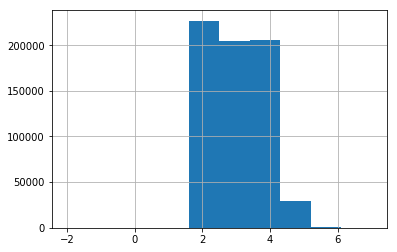

In [83]:
(X_train.sbytes+0.01).apply(np.log10).hist()

# Multi-class Classification


In [96]:
# Load train and test data
X_train_mc, y_train_mc = dp.load_agg_Xy(path='./data/', sample_size=0.35, strat_cat='attack_cat')

# Creating numeric class labels and reserving holdout
y_train_mc = y_train_mc.apply(lambda x:dp.attack_to_num[x])

X_train_mc, X_holdout_mc, y_train_mc, y_holdout_mc = train_test_split(X_train_mc, y_train_mc,
                                            test_size=0.25, stratify=y_train_mc)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3265: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3265: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [104]:
# Provide classifiers to test for a "first pass" assessment using only vanilla models
mc_classifiers = {
    'knn': KNeighborsClassifier,
    #'lgr': LogisticRegression,
    'gnb': GaussianNB,
    'dtc': DecisionTreeClassifier,
    'rfc': RandomForestClassifier,
    'gbc': GradientBoostingClassifier
}

mc_parameters = {
    'knn': {'n_neighbors':9},
    #'lgr': {'random_state':0,'solver':'lbfgs', 'multi_class':'ovr'},
    'gnb': {},
    'dtc': {'random_state':0},
    'rfc': {'random_state':0,'n_estimators':100},
    'gbc': {'random_state':0}
}

In [ ]:
scores_mc = moda.cross_val_models(mc_classifiers,
                                  ct.fit_transform(X_train_mc),
                                  y_train_mc,use_cv=skf,
                                  params=mc_parameters,
                                  metric='f1_weighted',
                                 verbose=True)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-s

Model: knn Metric: f1_weighted 0.9736719260079921
Model: gnb Metric: f1_weighted 0.8763110028814388


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: dtc Metric: f1_weighted 0.9771683628563779


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: rfc Metric: f1_weighted 0.9789895184832463


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
